In [ ]:
!gdown --id 1ulaHMFe6MBo_mexhaGUyM1rX3qY-UW11
!unzip /content/SketchNetData-20240412T115202Z-001.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ulaHMFe6MBo_mexhaGUyM1rX3qY-UW11
From (redirected): https://drive.google.com/uc?id=1ulaHMFe6MBo_mexhaGUyM1rX3qY-UW11&confirm=t&uuid=c52c87b4-899b-4649-aadc-71e6ced818bf
To: /content/SketchNetData-20240412T115202Z-001.zip
100% 413M/413M [00:02<00:00, 150MB/s]
Archive:  /content/SketchNetData-20240412T115202Z-001.zip
  inflating: SketchNet Data/Train.rar  
  inflating: SketchNet Data/Validation.rar  
  inflating: SketchNet Data/Validation.csv  
  inflating: SketchNet Data/Train.csv  


In [ ]:
import os

old_name = r"/content/SketchNet Data"
new_name = r"/content/SketchNetData"
os.rename(old_name, new_name)

In [ ]:
!pip install unrar
!unrar x /content/SketchNetData/Train.rar
!unrar x /content/SketchNetData/Validation.rar

Streaming output truncated to the last 5000 lines.
Extracting  Validation/1002.png                                            0%  OK 
Extracting  Validation/1003.png                                            0%  OK 
Extracting  Validation/1004.png                                            0%  OK 
Extracting  Validation/10041.png                                           0%  OK 
Extracting  Validation/10042.png                                           0%  OK 
Extracting  Validation/10043.png                                           0%  OK 
Extracting  Validation/10044.png                                           0%  OK 
Extracting  Validation/10045.png                                           0%  OK 
Extracting  Validation/10046.png                                           0%  OK 
Extracting  Validation/10047.png                                           0%  OK 
Extracting  Validation/10048.

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision.models import efficientnet_b0

import matplotlib.pyplot as plt
import numpy as np
import csv
from PIL import Image

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
batch_size = 128

In [ ]:
class SketchDataset(Dataset):
  def __init__(self, csv_file, root_dir,  transform=transforms.ToTensor()):

    self.root_dir = root_dir
    self.transform = transform

    with open(csv_file, 'r') as f:
      reader = csv.reader(f)
      classes = list(reader)

    self.csv_classes = np.array(classes)


  def __len__(self):
    return len(self.csv_classes)

  def __getitem__(self, idx):
    img = os.path.join(self.root_dir,self.csv_classes[idx][0]) + ".png"

    img = Image.open(img)
    if self.transform:
            img = self.transform(img)

    return img , int(self.csv_classes[idx][1])-1


In [ ]:
train_set = SketchDataset(csv_file='/content/SketchNetData/Train.csv',root_dir="/content/Train")
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
print(f"size of dataset {len(train_set)}")

img, _ = train_set[0]
print(f"picture dimensions {np.array(img).shape}")

print(f"classes {train_set.csv_classes}") #checking if stores classes properly, not actuall no of classes

size of dataset 10000
picture dimensions (1, 1111, 1111)
classes [['1' '1']
 ['10' '1']
 ['11' '1']
 ...
 ['7878' '99']
 ['7879' '99']
 ['7880' '99']]


In [ ]:
def display_dataset(train_loader):

  images, labels = next(iter(train_loader))
  fig = plt.figure()
  chosen_img = []
  for i in range(4):
      ax = plt.subplot(1, 4, i + 1)
      plt.tight_layout()

      while True:
        idx = np.random.randint(0, images.shape[0])
        if idx not in chosen_img:
          break
      chosen_img.append(idx)

      ax.set_title(f"class {labels[idx]}")
      ax.axis('off')
      plt.imshow(images[idx].permute(1,2,0))

      if i+1 == batch_size:
        break

  plt.show()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


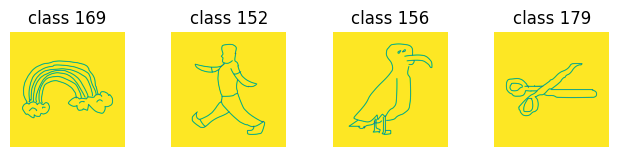

In [ ]:
display_dataset(train_loader)

## Augmentation

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.Resize(224),
    transforms.ToTensor(),
])

In [ ]:
train_set  = SketchDataset(csv_file='/content/SketchNetData/Train.csv',root_dir="/content/Train", transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

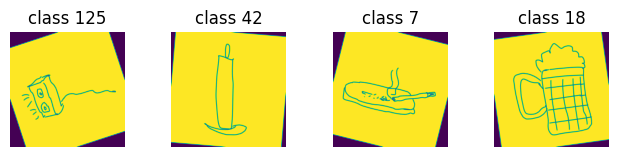

In [ ]:
display_dataset(train_loader)

In [ ]:
val_transform = transforms.Compose([torchvision.transforms.Resize(224),transforms.ToTensor()])#,transforms.Normalize(mean=mean, std=std)])
val_set  = SketchDataset(csv_file='/content/SketchNetData/Validation.csv',root_dir="/content/Validation", transform=val_transform)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)

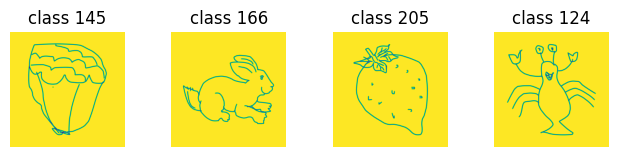

In [ ]:
display_dataset(val_loader)

## Backbone Model

In [ ]:
from torchvision.models import resnet50

backbone_model = nn.Sequential(*list(resnet50(pretrained=True).children())[:-2]).to(device)

for param in backbone_model.parameters():
    param.requires_grad = False

for param in backbone_model[-1].parameters():
    param.requires_grad = True

backbone_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


## Classfier

In [ ]:
class SketchNet(nn.Module):
  def __init__(self, backbone_model, input_size, classes, BN_momentum=0.5):
    super(SketchNet, self).__init__()

    self.input_size = input_size

    self.backbone = backbone_model

    self.flatten = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
    )

    self.classfier = nn.Sequential(

            nn.Dropout(0.5),
            nn.Linear(2048, 1500),
            nn.BatchNorm1d(1500, momentum=BN_momentum),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(1500, 1000),
            nn.BatchNorm1d(1000, momentum=BN_momentum),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(1000, 500),
            nn.BatchNorm1d(500, momentum=BN_momentum),
            nn.ReLU(),

            nn.Linear(500, classes)
    )

  def forward(self,x):

    if self.input_size[0] == 1:
      x = x.repeat(1, 3, 1, 1)

    features = self.backbone(x)
    flat = self.flatten(features)
    output = self.classfier(flat)

    return output




In [ ]:
model = SketchNet(backbone_model, (1,224,224),classes=250)

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

model.to(device)

SketchNet(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

### Training

In [ ]:
from tqdm import tqdm

def run_1_epoch(model, loss_fn, loader, optimizer = None, train = False):

  if train:
    model.train()
  else:
    model.eval()

  total_correct_preds = 0

  total_loss = 0

  total_samples_in_loader = len(loader.dataset)

  total_batches_in_loader = len(loader)

  for image_batch, labels in tqdm(loader):
    image_batch = image_batch.to(device)
    labels = labels.to(device)

    if train:
      assert optimizer is not None, "Optimizer must be provided if train=True"
      optimizer.zero_grad()

    output = model(image_batch)
    _, predicted = torch.max(output.data, 1)

    output.squeeze_(-1)

    loss = loss_function(output, labels)

    if train:
      loss.backward()

    if train:
      optimizer.step()

    total_correct_preds += (predicted == labels).sum().item()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = 100 * total_correct_preds / total_samples_in_loader

  return loss, accuracy

In [ ]:
train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

val_accuracy_max = 0

best_val_checkpoint_path = "best_checkpoint"

checkpoint_path = "model_checkpoint"

In [ ]:
epochs = 8
start_epoch = 0

# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, train_accuracy  = run_1_epoch(model, loss_function, train_loader, optimizer, train= True)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_loss_list.append(train_loss)
  train_accuracy_list.append(train_accuracy)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy  = run_1_epoch(model, loss_function, val_loader, optimizer, train= False)

  # Lists for val loss and accuracy for plotting
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))

  if val_accuracy > val_accuracy_max:
    val_accuracy_max = val_accuracy
    print("New max val Accuracy Acheived %.2f. Saving model.\n\n"%(val_accuracy_max))

    checkpoint = {
      'model': model.state_dict(),
      'optimizer': optimizer.state_dict(),
      'scheduler': scheduler.state_dict(),
      'trianed_epochs': epoch,
      'train_losses': train_loss_list,
      'train_accuracies': train_accuracy_list,
      'val_losses': val_loss_list,
      'val_accuracies': val_accuracy_list,
      'val_accuracy_max': val_accuracy_max,
      'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("val accuracy did not increase from %.2f\n\n"%(val_accuracy_max))

  checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }

  torch.save(checkpoint, checkpoint_path)

Epoch 0: Train 
Learning Rate: 0.001000


100%|██████████| 79/79 [01:55<00:00,  1.46s/it]


Epoch 0: Validation


100%|██████████| 40/40 [00:33<00:00,  1.18it/s]


train loss: 4.9851
val loss: 4.2892
train_accuracy 3.58
val_accuracy 7.68
New max val Accuracy Acheived 7.68. Saving model.


Epoch 1: Train 
Learning Rate: 0.001000


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]


Epoch 1: Validation


100%|██████████| 40/40 [00:33<00:00,  1.18it/s]


train loss: 3.7283
val loss: 3.2348
train_accuracy 14.00
val_accuracy 21.26
New max val Accuracy Acheived 21.26. Saving model.


Epoch 2: Train 
Learning Rate: 0.001000


100%|██████████| 79/79 [01:53<00:00,  1.43s/it]


Epoch 2: Validation


100%|██████████| 40/40 [00:32<00:00,  1.21it/s]


train loss: 3.1054
val loss: 2.9372
train_accuracy 23.62
val_accuracy 25.54
New max val Accuracy Acheived 25.54. Saving model.


Epoch 3: Train 
Learning Rate: 0.001000


100%|██████████| 79/79 [01:51<00:00,  1.41s/it]


Epoch 3: Validation


100%|██████████| 40/40 [00:34<00:00,  1.18it/s]


train loss: 2.7019
val loss: 2.4920
train_accuracy 30.08
val_accuracy 35.78
New max val Accuracy Acheived 35.78. Saving model.


Epoch 4: Train 
Learning Rate: 0.001000


100%|██████████| 79/79 [01:54<00:00,  1.44s/it]


Epoch 4: Validation


100%|██████████| 40/40 [00:33<00:00,  1.19it/s]


train loss: 2.4514
val loss: 2.4393
train_accuracy 35.10
val_accuracy 36.56
New max val Accuracy Acheived 36.56. Saving model.


Epoch 5: Train 
Learning Rate: 0.001000


100%|██████████| 79/79 [01:51<00:00,  1.41s/it]


Epoch 5: Validation


100%|██████████| 40/40 [00:33<00:00,  1.18it/s]


train loss: 2.2176
val loss: 2.3031
train_accuracy 40.28
val_accuracy 39.72
New max val Accuracy Acheived 39.72. Saving model.


Epoch 6: Train 
Learning Rate: 0.001000


100%|██████████| 79/79 [01:56<00:00,  1.48s/it]


Epoch 6: Validation


100%|██████████| 40/40 [00:33<00:00,  1.19it/s]


train loss: 2.0887
val loss: 2.1630
train_accuracy 43.27
val_accuracy 44.60
New max val Accuracy Acheived 44.60. Saving model.


Epoch 7: Train 
Learning Rate: 0.001000


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]


Epoch 7: Validation


100%|██████████| 40/40 [00:33<00:00,  1.18it/s]


train loss: 1.9163
val loss: 2.1371
train_accuracy 47.72
val_accuracy 44.90
New max val Accuracy Acheived 44.90. Saving model.




Text(0.5, 1.0, 'Training and val Loss')

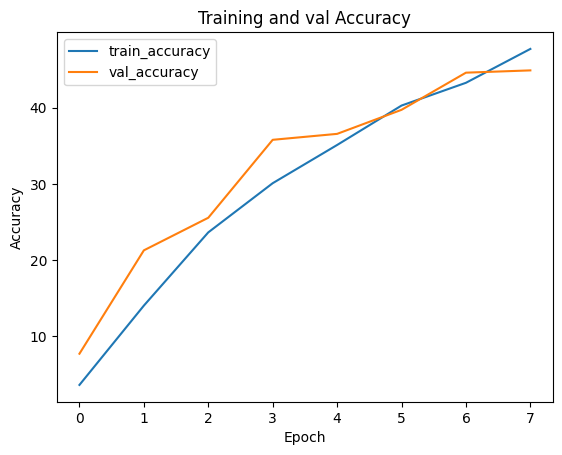

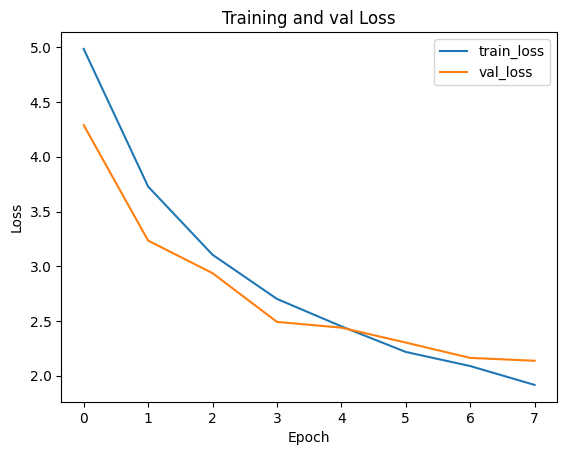

In [ ]:
plt.figure()
plt.plot(train_accuracy_list, label="train_accuracy")
plt.plot(val_accuracy_list, label="val_accuracy")
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and val Accuracy')

plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.plot(val_loss_list, label="val_loss")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and val Loss')

In [ ]:
import csv

# Define the path to the test folder and the output CSV file
!gdown --id 1CTsseN_yFS-fSSmYHyYM536E3baxERvu
!unzip /content/Test.zip
test_folder = "/content/Test"
output_csv = "predictions.csv"

# Create a list to store the predicted labels and image names
predictions = []

# Set the model to evaluation mode
model.eval()

# Iterate over the images in the test folder
for image_name in os.listdir(test_folder):
    # Load the image
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path).convert('L')
    image = image.convert('RGB')

    # Apply transformations
    image = val_transform(image)
    image = image.unsqueeze(0)  # Add a batch dimension

    # Move the image to the appropriate device
    image = image.to(device)

    # Forward pass
    with torch.no_grad():
        output = model(image)

    # Get the predicted class index
    _, predicted = torch.max(output, 1)
    predicted_label = predicted.item() + 1  # Add 1 to match the original label indexing

    # Store the image name and predicted label in the list
    predictions.append([image_name, predicted_label])

# Save the predictions to a CSV file
with open(output_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["ImageName", "PredictedLabel"])  # Write the header row
    writer.writerows(predictions)

print("Predictions saved to", output_csv)

Streaming output truncated to the last 5000 lines.
  inflating: Test/img_1000061.png    
replace Test/img_1000636.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Test/img_1000636.png    
  inflating: Test/img_1001266.png    
  inflating: Test/img_1004991.png    
  inflating: Test/img_1007083.png    
  inflating: Test/img_1007562.png    
  inflating: Test/img_1009343.png    
  inflating: Test/img_1010798.png    
  inflating: Test/img_1013430.png    
  inflating: Test/img_1016387.png    
  inflating: Test/img_1017623.png    
  inflating: Test/img_1021160.png    
  inflating: Test/img_1021711.png    
  inflating: Test/img_1022733.png    
  inflating: Test/img_1024815.png    
  inflating: Test/img_1025165.png    
  inflating: Test/img_1027218.png    
  inflating: Test/img_1029097.png    
  inflating: Test/img_1030111.png    
  inflating: Test/img_1030577.png    
  inflating: Test/img_1030849.png    
  inflating: Test/img_1035252.png    
  inflating: Test/img_1036997.png    
  inf

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 9, 224, 224] to have 3 channels, but got 9 channels instead

## Predicting

In [ ]:
best_checkpoint = torch.load("best_checkpoint", map_location=torch.device('cpu'))
print("current model", model.state_dict().keys())
print("saved model", best_checkpoint.keys())

model.load_state_dict(best_checkpoint)
with torch.no_grad():
  val_loss_finalmodel, val_accuracy_finalmodel = run_1_epoch(model, loss_function, val_loader, optimizer, train= False)
  print('val loss finalmodel: %.4f'%(val_loss_finalmodel))
  print('val_accuracy finalmodel %.2f' % (val_accuracy_finalmodel))


In [ ]:
class SketchDatasetEval(Dataset):
  def __init__(self, csv_file, root_dir,  transform=transforms.ToTensor()):

    self.root_dir = root_dir
    self.transform = transform

    with open(csv_file, 'r') as f:
      reader = csv.reader(f)
      classes = list(reader)

    self.csv_classes = np.array(classes)


  def __len__(self):
    return len(self.csv_classes)

  def __getitem__(self, idx):
    img_path = os.path.join(self.root_dir,self.csv_classes[idx][0]) + ".png"

    img = Image.open(img_path)
    if self.transform:
            img = self.transform(img)

    return img , int(self.csv_classes[idx][1])-1, img_path


In [ ]:
import csv

def results(loader,model,type_set=""):
  # Create a CSV file
  with open(f'predictions_{type_set}.csv', mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['Image', 'Predicted Label', 'True Label'])

      with torch.no_grad():
          for images, labels, img_paths in loader:
              images = images.to(device)
              labels = labels.to(device)

              predicted_labels = model(images)
              predicted_labels = torch.argmax(predicted_labels, 1)


              for i in range(len(images)):
                  image_name = f'image_{i}'
                  predicted_label = predicted_labels[i].item()
                  if type_set == "test":
                    true_label = labels[i].item()
                  else:
                    true_label = "Nan"
                  writer.writerow([img_paths[i], predicted_label+1,true_label+1])

In [ ]:
train_set = SketchDatasetEval(csv_file='/content/SketchNetData/Train.csv',root_dir="/content/Train")
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

val_set  = SketchDatasetEval(csv_file='/content/SketchNetData/Validation.csv',root_dir="/content/Validation")
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
results(train_loader,model,"train")
results(val_loader,model,"train")

## Testing and Evaluation

In [ ]:
!unrar x Test.rar

In [ ]:
#waiting for miss to upload the test files
test_set = SketchDatasetEval(csv_file='/content/Test.csv',root_dir="/content/Train")
test_loader = ""

In [ ]:
with torch.no_grad():
    test_loss, test_accuracy  = run_1_epoch(model, loss_function, test_loader, train= False)

print('test loss: %.4f'%(test_loss))
print('test_accuracy %.2f' % (test_accuracy))

## Examples

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

files.download(best_val_checkpoint_path)

save_path = '/content/drive/My Drive/sketchModels/resnet50_imgNET.pth'


torch.save(model.state_dict(), save_path)    #change name everytime u train (also this doesnt
                                             #consider best model during training, j the last one)

